In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import ContrastiveWrapper

from pytorch_lightning import Trainer

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [3]:
parser = get_parser()
args = parser.parse_args('''
--dataset UCI-HAR --batch_size 128 --window_size 40 --normalize --subjects_for_test 21 20 19 18 17 
--max_epochs 10 --lr 0.01 --training_dir training_clr --n_val_subjects 4 --reduce_imbalance
--encoder_architecture cnn_gap_ts --encoder_features 20 --cf 0.001 --mode img --pattern_type med --pattern_size 30'''.split())

dm = load_dm(args)

Loaded dataset UCI-HAR with a total of 815614 observations for window size 40
Computing medoids...
Computing dissimilarity frames...
hash of computed patterns: UCI-HAR_d77c08a9a6e727ab2e0aaf0484955844ad473342
Sampling 71712 (balanced) observations per epoch.
Using 631395 observations for training, 106617 for validation and 143333 for test


In [31]:
sts = dm.stsds.STS
sts_slice = dm.stsds.STS[:, 1000:3000]
scs = dm.stsds.SCS
scs_slice = dm.stsds.SCS[1000:3000]
x_index = np.arange(scs_slice.shape[0])

AttributeError: 'LDFDataset' object has no attribute 'stsds'

In [5]:
points = np.hstack([x_index, sts_slice[0]]).reshape(-1, 1, 2)

In [6]:
from matplotlib.colors import ListedColormap
from data.har.label_mappings import UCI_HAR_LABELS

In [7]:
UCI_HAR_LABELS

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING',
 7: 'STAND_TO_SIT',
 8: 'SIT_TO_STAND',
 9: 'SIT_TO_LIE',
 10: 'LIE_TO_SIT',
 11: 'STAND_TO_LIE',
 12: 'LIE_TO_STAND'}

In [131]:
lcmap = ["r", "g", "b", "yellow", "orange", "darkviolet", "lime", "cyan", "gray", "darkblue", "tomato", "magenta"]

In [132]:
uci_bars = ['Walk',
 'Stairs-up',
 'Stairs-down',
 'Sit',
 'Stand',
 'Lie',
 'Stand-Sit',
 'Sit-Stand',
 'Sit-Lie',
 'Lie-Sit',
 'Stand-Lie',
 'Lie-Stand']

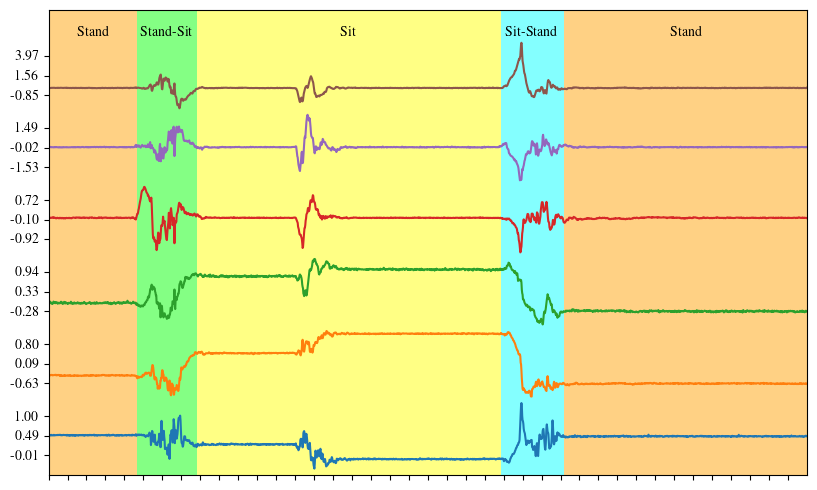

In [29]:
num_lines = 6
fig, ax = plt.subplots(1, 1, figsize=(8.27, 5))

ax.set_xlim([0, scs_slice.shape[0]])
ax.set_ylim([-.1, num_lines + .1*num_lines + .4])

yticks = []
yticks_val = []
for i in range(num_lines):

    ax.plot(x_index, (sts_slice[i] - sts_slice[i].min()) /(sts_slice[i] - sts_slice[i].min()).max() + 1.1*i)


    range_current_line = (sts_slice[i].max() - sts_slice[i].min()).item()
    min_current_line = sts_slice[i].min().item()
    yticks += [1.1*i + 0.2, 1.1*i+0.5, 1.1*i+.8]
    yticks_val += [min_current_line+range_current_line*.2, min_current_line+range_current_line*.5, min_current_line+range_current_line*.8]

    last = 0
    for j in list(np.nonzero(np.diff(scs_slice))[0]) + [scs_slice.shape[0]]:
        if i==0:
            ax.text((last + j)/2-8*len(uci_bars[scs_slice[j-1].item()]), 1.1*num_lines, uci_bars[scs_slice[j-1].item()])
        ax.axvspan(last, j, 0, 1, facecolor=lcmap[scs_slice[j-1]], alpha=.1)
        last = j

yticks_val = [f"{n:.2f}" for n in yticks_val]

ax.set_yticks(yticks, yticks_val)
ax.set_xticks([i for i in range(0, scs_slice.shape[0], 50)], [])

plt.tight_layout()
plt.savefig("out.svg")

In [17]:
dmpart = dm.dfds.DM[0]

In [74]:
from transforms.odtw import compute_oDTW, compute_oDTW_channel

In [87]:
np.min(curr_pattern)

-0.793901850752387

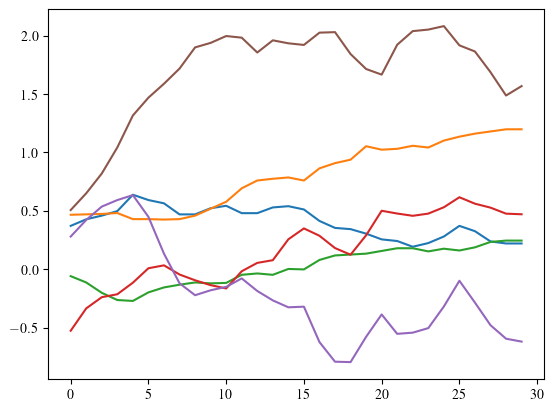

In [88]:
for j in range(curr_pattern.shape[0]):
    plt.plot(curr_pattern[j, ::-1])

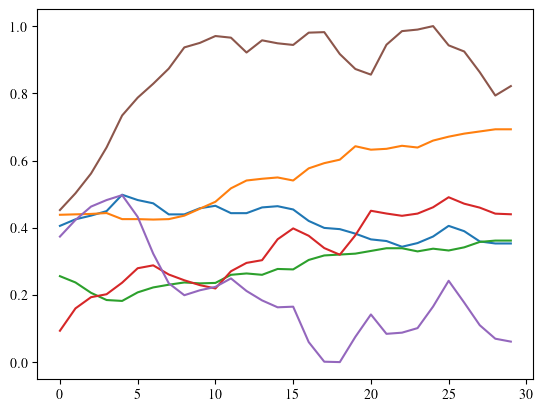

In [89]:
for j in range(curr_pattern.shape[0]):
    plt.plot((curr_pattern[j, ::-1] - np.min(curr_pattern))/(np.max(curr_pattern) - np.min(curr_pattern)))

In [128]:
scs_slice = dm.dfds.stsds.SCS[1000:3000]

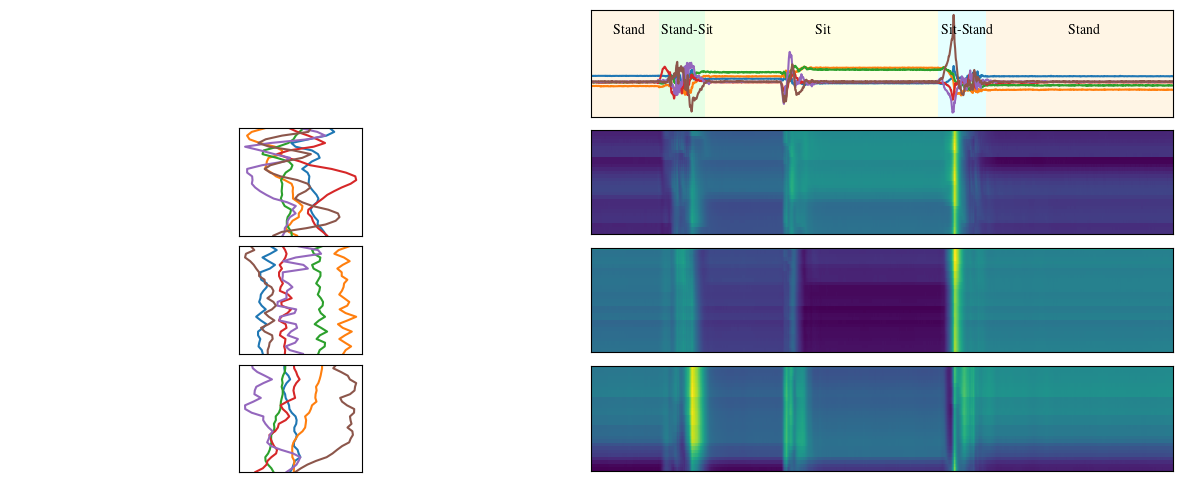

In [138]:
fig, ax = plt.subplots(4, 2, figsize=(15, 6), gridspec_kw= {'wspace':0, "hspace": .1})

ensenar = [0, 8, 11]

for i in range(3):
    curr_pattern = dm.dfds.patterns[ensenar[i]]
    for j in range(curr_pattern.shape[0]):
        ax[i+1, 0].plot((curr_pattern[j, ::-1] - np.min(curr_pattern))/(np.max(curr_pattern) - np.min(curr_pattern))*30, np.arange(curr_pattern[j, :].shape[0]))

    ax[i+1, 0].set_aspect("equal")
    ax[i+1, 0].set_yticks([])
    ax[i+1, 0].set_xticks([])
    ax[i+1, 0].set_ylim([0, 29])

    ax[i+1, 1].set_xticks([])
    ax[i+1, 1].set_yticks([])
    ax[i+1, 1].imshow(np.repeat(dmpart[1000:3000, ensenar[i], :].T, 12, 0), interpolation="none")

for j in range(dm.dfds.stsds.STS.shape[0]):
    ax[0, 1].plot(dm.dfds.stsds.STS[j, 1000:3000])

last=0
for j in list(np.nonzero(np.diff(scs_slice))[0]) + [scs_slice.shape[0]]:
    ax[0, 1].text((last + j)/2-8*len(uci_bars[scs_slice[j-1].item()]), 4, uci_bars[scs_slice[j-1].item()])
    ax[0, 1].axvspan(last, j, 0, 1, facecolor=lcmap[scs_slice[j-1]], alpha=.1)
    last = j

ax[0, 1].set_xlim([0, 2000])
ax[0, 0].axis("off")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

fig.savefig("out.svg")